In [4]:
html
<style>.container {width: 80% !important;}</style>

In [1]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader 
import PIL
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler

In [10]:
n_classes = 21
batch_size = 4
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [2]:
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [3]:
test_data = datasets.VOCSegmentation("data", year='2012', download=True, image_set='val', transform=image_transform, target_transform=mask_transform)

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
Extracting data/VOCtrainval_11-May-2012.tar to data


In [5]:
class FcnModel(nn.Module):
    def __init__(self, n_classes, convert_maxpool = False):
        super().__init__()
        self.n_classes = n_classes
        # Load the VGG16 pretrained model
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # Extract features from VGG16
        features = list(vgg.features.children())

        # Convert max pooling to average pooling optional
        if convert_maxpool:
            for i in range(len(features)):
                if isinstance(features[i], nn.MaxPool2d):
                    features[i] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        # Define the FCN architecture, But back the features in a sequential manner for passing the data
        self.features = nn.Sequential(*features)

        # Upsampling layers using ConvTranspose2d
        self.upsample1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.upsample5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        x = self.features(x)
        x = self.bn1(self.upsample1(x))
        x = self.bn2(self.upsample2(x))
        x = self.bn3(self.upsample3(x))
        x = self.bn4(self.upsample4(x))
        x = self.bn5(self.upsample5(x))
        x = self.classifier(x)

        return x

## Model Loading

In [12]:
model = FcnModel(n_classes=21).to(device)
model.load_state_dict(torch.load('model_weights_simple_fcn_no_skip.pth'))

<All keys matched successfully>

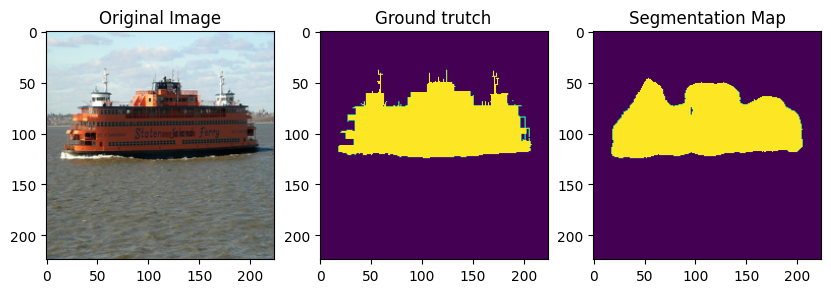

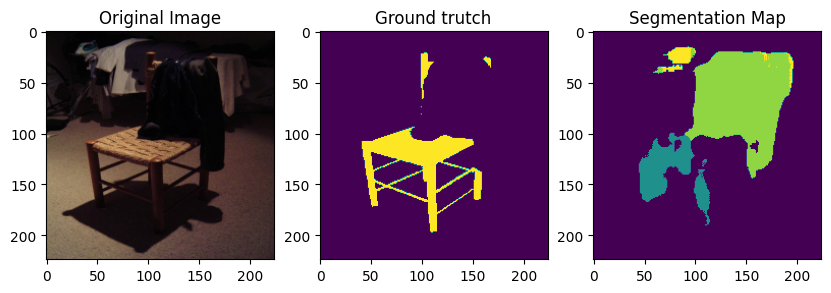

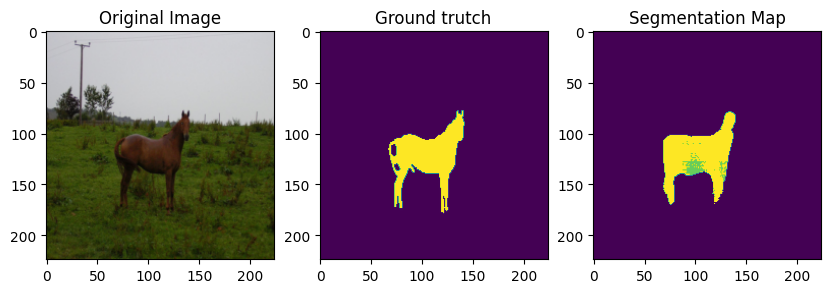

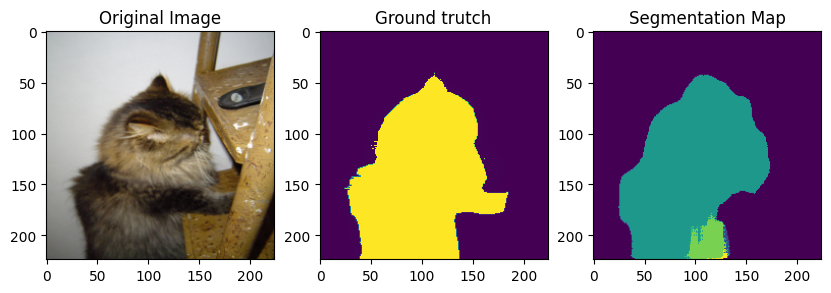

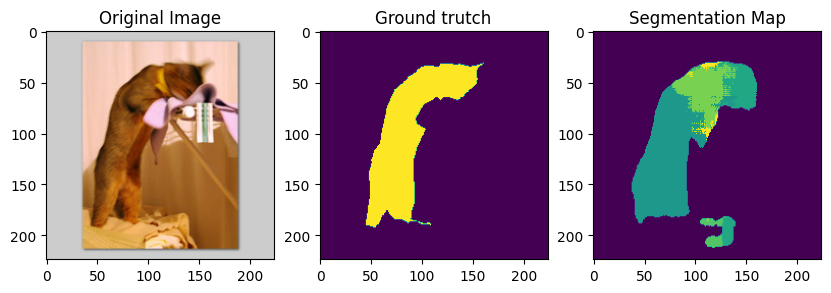

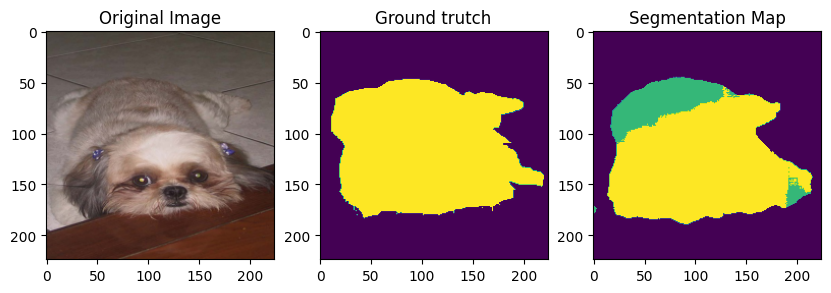

In [22]:
rand_ids = np.random.randint(1,len(test_data), 6)
def unnormalize(tensor):
    """Revert normalization on a tensor."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

model.eval()
with torch.no_grad():
    for id in rand_ids:
        image, ground_truth = test_data[id]
        image_d = image.to(device) 
        ground_truth = ground_truth.squeeze()    
#       image = image.permute(1, 2, 0)
        output = model(image_d.unsqueeze(dim=0))
        # Convert the output tensor to a segmentation map
        _, predicted = torch.max(output.data, 1)
        seg_map = predicted.squeeze().cpu().numpy()
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        #convert the image and mask back to its values 0 to 255 , transform it back from .ToTensor()
        image_unnorm = unnormalize(image.clone())
        ground_truth_unnorm = transforms.ToPILImage()(ground_truth * 255)    
        
        axs[0].imshow(image_unnorm.permute(1,2,0))
        axs[0].title.set_text('Original Image')
        axs[1].imshow(ground_truth_unnorm)
        axs[1].title.set_text('Ground trutch')
        axs[2].imshow(seg_map)
        axs[2].title.set_text('Segmentation Map')
        plt.show()